Aviso: paquete 'neal' no encontrado. Se usará un sustituto QAOA en Qiskit para 'simulated_annealing_solve'.


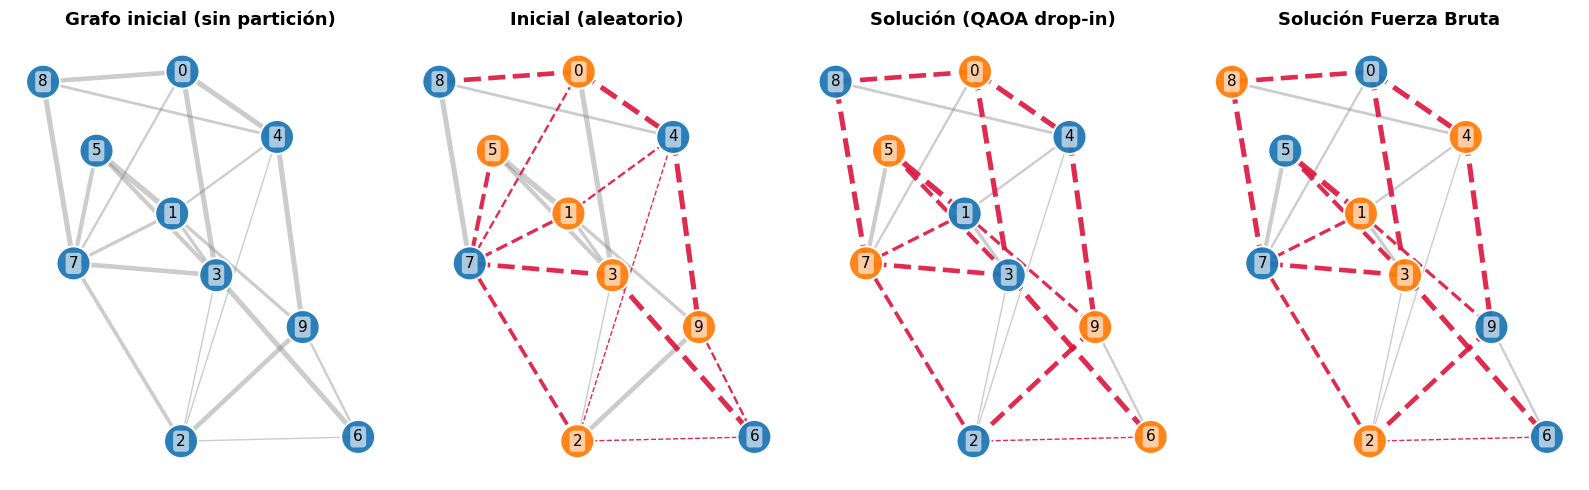

G: n=10, m=22
Must-link pairs: [(4, 6), (4, 5)]
Cannot-link pairs: [(1, 3), (0, 7)]

== Fuerza bruta ==
E_min: -103.0
  partition: (5, 5) cut_w: 103.0 must_viol: 2 cannot_viol: 2
  partition: (5, 5) cut_w: 103.0 must_viol: 2 cannot_viol: 2

== Simulated Annealing (neal) [QAOA drop-in] ==
E_min SA/QAOA: -103.0
  partition: (5, 5) cut_w: 103.0 must_viol: 2 cannot_viol: 2
  partition: (5, 5) cut_w: 103.0 must_viol: 2 cannot_viol: 2


In [1]:
# Requisitos:
# pip install networkx matplotlib numpy qiskit qiskit-aer
# (neal ya no es necesario; mantenemos el bloque para cambio mínimo)

import itertools
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# intentar importar neal (Simulated Annealing)
try:
    import neal
    HAS_NEAL = True
except Exception:
    HAS_NEAL = False
    print("Aviso: paquete 'neal' no encontrado. Se usará un sustituto QAOA en Qiskit para 'simulated_annealing_solve'.")

# ----------------------------
# 1) Generar grafo ponderado
# ----------------------------
def generate_weighted_graph(n, p=0.4, weight_range=(1,10), seed=None):
    """
    Genera un grafo aleatorio G(n, p) con pesos en aristas.
    Devuelve un objeto networkx.Graph con atributo 'weight' en cada arista.
    """
    rng = random.Random(seed)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if rng.random() < p:
                w = rng.randint(*weight_range)
                G.add_edge(i, j, weight=float(w))
    return G

# ---------------------------------------
# 2) Seleccionar pares must-link/cannot-link
# ---------------------------------------
def pick_constraints(G, num_must=0, num_cannot=0, seed=None):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    all_pairs = [(i,j) for i in nodes for j in nodes if i<j]
    rng.shuffle(all_pairs)
    must = []
    cannot = []
    idx = 0
    while len(must) < num_must and idx < len(all_pairs):
        must.append(all_pairs[idx]); idx+=1
    while len(cannot) < num_cannot and idx < len(all_pairs):
        # evitar repetir pares ya en must
        if all_pairs[idx] not in must:
            cannot.append(all_pairs[idx])
        idx += 1
    return must, cannot

# ------------------------------------------------
# 3) Construir el diccionario QUBO
# ------------------------------------------------
def build_qubo(G, A=None, B=None, C=None):
    """
    Construye un QUBO dict {(i,j): Q_ij} (i<=j) que representa:
      E = E_cut + A * E_balance + B * sum_must (xi - xj)^2 + C * sum_cannot (xi + xj -1)^2
    donde E_cut (a minimizar) se codifica como -sum_w * (xi xor xj) => se deriva a términos QUBO.
    """
    n = G.number_of_nodes()
    Q = defaultdict(float)

    # --- Término corte ponderado (Max-Cut convertido a minimización) ---
    # Maximizar sum_w (xi xor xj)  <=> Minimizar - sum_w (xi xor xj)
    # xi xor xj = xi + xj - 2 xi xj
    # => -w*(xi + xj - 2 xi xj) = -w xi - w xj + 2 w xi xj
    for (i,j,data) in G.edges(data=True):
        w = float(data.get('weight', 1.0))
        Q[(i,i)] += -w
        Q[(j,j)] += -w
        # cuadrático i,j
        a = 2.0 * w
        key = (i,j) if i<=j else (j,i)
        Q[key] += a

    # --- Balanceo de partición: A * (sum_i xi - n/2)^2 ---
    # Expandir: A * (sum xi^2 + 2 sum_{i<j} xi xj - n sum xi + const)
    # xi^2 = xi
    n_half = n / 2.0
    # lineales
    for i in G.nodes():
        Q[(i,i)] += A * (1.0 - n)  # A*(xi - n/2)^2 -> A*xi  y  -A*n*xi  => A*(1 - n)
    # pairwise terms
    for i in G.nodes():
        for j in G.nodes():
            if i<j:
                Q[(i,j)] += 2.0 * A

    # El término constante A*(n_half^2) se ignora

    return dict(Q)

# ------------------------------------------------
# 3b) Añadir restricciones must-link y cannot-link al QUBO
# ------------------------------------------------
def add_must_cannot_to_qubo(Q_in, must_pairs, cannot_pairs, B=None, C=None):
    """
    Añade al QUBO existente las penalizaciones:
      must-link (i,j): B * (xi - xj)^2 = B*(xi + xj -2 xi xj)
      cannot-link (i,j): C * (xi + xj - 1)^2 = C*(xi + xj - 2 xi xj -1 + const)
    Devuelve nuevo diccionario Q (i<=j).
    """
    Q = defaultdict(float, Q_in)  # copia
    for (i,j) in must_pairs:
        # B*(xi + xj -2 xi xj)
        Q[(i,i)] += B
        Q[(j,j)] += B
        Q[(i,j)] += -2.0 * B

    for (i,j) in cannot_pairs:
        # C*(xi + xj - 2 xi xj -1)  (const -1 ignorable)
        Q[(i,i)] += -C
        Q[(j,j)] += -C
        Q[(i,j)] += 2.0 * C
        # Note: There's also a constant -C which doesn't affect argmin

    return dict(Q)

# ------------------------------------------------
# Helpers para evaluar una solución binaria x (dict or list)
# ------------------------------------------------
def energy_of_solution(Q, x):
    """
    Q: dict (i<=j): value
    x: dict {i:0/1} o list/array
    """
    # convertir x a diccionario
    if isinstance(x, (list, tuple, np.ndarray)):
        xdict = {i:int(v) for i,v in enumerate(x)}
    else:
        xdict = {i:int(v) for i,v in x.items()}

    E = 0.0
    for (i,j),val in Q.items():
        xi = xdict[i]
        xj = xdict[j] if i!=j else xi
        if i==j:
            E += val * xi
        else:
            E += val * xi * xj
    return float(E)

def solution_metrics(G, x):
    """
    Devuelve: partition_sizes (n0,n1), cut_weight, must_violations, cannot_violations
    x: list/dict mapping node->0/1
    """
    if isinstance(x, (list, tuple, np.ndarray)):
        xdict = {i:int(v) for i,v in enumerate(x)}
    else:
        xdict = {i:int(v) for i,v in x.items()}

    n0 = sum(1 for v in xdict.values() if v==0)
    n1 = sum(1 for v in xdict.values() if v==1)

    cut_weight = 0.0
    for i,j,data in G.edges(data=True):
        if xdict[i] != xdict[j]:
            cut_weight += float(data.get('weight',1.0))

    return (n0, n1), cut_weight

# ------------------------------------------------
# 4) Solvers: Fuerza bruta y Simulated Annealing (neal)
#    *** CAMBIO MÍNIMO: 'simulated_annealing_solve' ahora implementa QAOA ***
# ------------------------------------------------
def brute_force_solve(Q, n):
    """
    Recorre las 2^n soluciones (solo práctico para n <= ~22).
    Devuelve: min_energy, list_of_best_solutions (each as list of 0/1), all_energies(optional)
    """
    best = None
    best_sols = []
    for bits in range(1<<n):
        x = [(bits>>i)&1 for i in range(n)]
        E = energy_of_solution(Q, x)
        if (best is None) or (E < best - 1e-12):
            best = E
            best_sols = [x]
        elif abs(E - best) < 1e-12:
            best_sols.append(x)
    return best, best_sols

def simulated_annealing_solve(Q, n, num_reads=1000, seed=None):
    """
    Sustituto mínimo: usa QAOA (Qiskit) para minimizar la energía QUBO y muestrear.
    Mantiene la MISMA interfaz y retornos que la versión con neal:
      -> devuelve (best_energy, list_of_best_solutions)
    'num_reads' se mapea a 'shots' del simulador cuántico.
    """
    # Importes locales (no cambiamos cabecera del archivo)
    from qiskit import QuantumCircuit, transpile
    from qiskit.circuit import Parameter
    from qiskit.circuit.library import RZZGate, RXGate
    from qiskit.quantum_info import Statevector
    from qiskit_aer import AerSimulator

    rng = np.random.default_rng(seed)
    p_layers = 2  # profundidad QAOA ligera (puedes subirla)

    # QUBO -> Ising: x_i = (1 - Z_i)/2
    def qubo_to_ising(Q, n):
        J = np.zeros((n, n), dtype=float)
        h = np.zeros(n, dtype=float)
        const = 0.0
        for (i, j), val in Q.items():
            if i == j:
                const += val / 2.0
                h[i]   += -val / 2.0
            else:
                const += val / 4.0
                h[i]   += -val / 4.0
                h[j]   += -val / 4.0
                J[min(i,j), max(i,j)] += val / 4.0
        return J, h, const

    J, h, _ = qubo_to_ising(Q, n)

    # Ansatz QAOA: |+>^n ; coste Ising (RZ, RZZ) ; mixer X (RX)
    def build_qaoa_ansatz(n, J, h, P):
        qc = QuantumCircuit(n, name="QAOA_Ising")
        for q in range(n): qc.h(q)
        gammas = [Parameter(f"γ_{k}") for k in range(P)]
        betas  = [Parameter(f"β_{k}") for k in range(P)]
        pairs = [(i, j) for i in range(n) for j in range(i+1, n) if abs(J[i, j]) > 1e-15]
        for k in range(P):
            γ, β = gammas[k], betas[k]
            for i in range(n):
                if abs(h[i]) > 1e-15:
                    qc.rz(2.0 * γ * h[i], i)
            for (i, j) in pairs:
                qc.append(RZZGate(2.0 * γ * J[i, j]), [i, j])
            for q in range(n):
                qc.append(RXGate(2.0 * β), [q])
        return qc, gammas + betas

    ansatz, theta_params = build_qaoa_ansatz(n, J, h, p_layers)

    def bind_params(circ, mapping):
        try:
            return circ.assign_parameters(mapping, inplace=False)
        except Exception:
            try:
                return circ.bind_parameters(mapping)
            except Exception as e:
                raise RuntimeError(f"No se pudieron asignar parámetros: {e}")

    # Energía esperada del QUBO (para optimizar)
    def expected_energy(theta):
        circ_b = bind_params(ansatz, {p: float(t) for p, t in zip(theta_params, theta)})
        sv = Statevector.from_instruction(circ_b)
        amps = sv.data
        exp = 0.0
        for idx, amp in enumerate(amps):
            p = (amp.conjugate() * amp).real
            if p < 1e-16:
                continue
            z = np.array(list(np.binary_repr(idx, width=n))[::-1], dtype=int)  # little-endian -> z[0]=q0
            exp += p * energy_of_solution(Q, z)
        return float(exp)

    # Optimización ligera (COBYLA si SciPy; si no, búsqueda aleatoria)
    try:
        from scipy.optimize import minimize
        use_scipy = True
    except Exception:
        use_scipy = False

    def random_theta():
        return np.concatenate([
            rng.uniform(0, 2*np.pi, size=p_layers),  # gammas
            rng.uniform(0, 2*np.pi, size=p_layers),  # betas
        ])

    if use_scipy:
        best_val, best_theta = np.inf, None
        for _ in range(4):
            x0 = random_theta()
            res = minimize(expected_energy, x0, method="COBYLA",
                           options={"maxiter": 200, "rhobeg": 0.5})
            if res.fun < best_val:
                best_val, best_theta = res.fun, res.x
    else:
        best_val, best_theta = np.inf, None
        for _ in range(80):
            th = random_theta()
            val = expected_energy(th)
            if val < best_val:
                best_val, best_theta = val, th

    # Muestreo (shots = num_reads)
    backend = AerSimulator()
    meas_qc = bind_params(ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)}).copy()
    meas_qc.measure_all()
    tqc = transpile(meas_qc, backend, optimization_level=1, seed_transpiler=seed)
    res = backend.run(tqc, shots=int(num_reads), seed_simulator=seed).result()
    counts = res.get_counts()

    # Selección de mejores soluciones por energía (formato idéntico al de SA)
    best_E = None
    best_samples = []
    for s, c in counts.items():
        z = np.array(list(s[::-1]), dtype=int)  # Qiskit -> little-endian
        E = energy_of_solution(Q, z)
        if (best_E is None) or (E < best_E - 1e-12):
            best_E = float(E)
            best_samples = [z.tolist()]
        elif abs(E - best_E) < 1e-12:
            best_samples.append(z.tolist())

    return float(best_E), best_samples

# ------------------------------------------------
# 5) Visualización
# ------------------------------------------------
def plot_graph_partition(G, x, ax=None, title=None, node_size=600, pos=None, weight_scaling=True):
    """
    Dibuja el grafo coloreando los nodos según la partición x (0/1),
    con aristas ponderadas y corte resaltado.
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    # convertir x en diccionario
    if isinstance(x, (list, tuple, np.ndarray)):
        xdict = {i:int(v) for i,v in enumerate(x)}
    else:
        xdict = {i:int(v) for i,v in x.items()}

    # layout fijo o reproducible
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    # Colores de nodos (paleta más viva y contrastada)
    colors = ['#1f77b4' if xdict[n]==0 else '#ff7f0e' for n in G.nodes()]
    nx.draw_networkx_nodes(
        G, pos, node_color=colors, ax=ax, node_size=node_size,
        edgecolors='white', linewidths=1.5, alpha=0.95
    )

    # Separar aristas cortadas y no cortadas
    cut_edges = [(u,v) for u,v in G.edges() if xdict[u] != xdict[v]]
    same_edges = [(u,v) for u,v in G.edges() if xdict[u] == xdict[v]]

    # Extraer pesos (para grosor visual)
    weights = [G[u][v].get('weight',1.0) for u,v in G.edges()]
    w_min, w_max = (min(weights), max(weights)) if weights else (1.0, 1.0)
    normalize = lambda w: 1.0 + 3.0*(w - w_min)/(w_max - w_min + 1e-9) if weight_scaling and w_max>0 else 1.5

    # Aristas no cortadas (más claras)
    nx.draw_networkx_edges(
        G, pos, edgelist=same_edges, ax=ax,
        width=[normalize(G[u][v].get('weight',1.0)) for u,v in same_edges],
        edge_color='gray', alpha=0.4
    )

    # Aristas cortadas (resaltadas)
    nx.draw_networkx_edges(
        G, pos, edgelist=cut_edges, ax=ax,
        width=[normalize(G[u][v].get('weight',1.0)) for u,v in cut_edges],
        edge_color='crimson', style='dashed', alpha=0.9
    )

    # Etiquetas de nodos
    nx.draw_networkx_labels(
        G, pos, ax=ax, font_size=11,
        font_color='black',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')
    )

    if title:
        ax.set_title(title, fontsize=13, fontweight='bold')

    ax.axis('off')
    return ax

# ------------------------------------------------
# 6) Función de utilidad que ejecuta todo el flujo
#    (cambio mínimo: siempre usamos simulated_annealing_solve, ahora QAOA)
# ------------------------------------------------
def run_instance(n=10, p=0.4, weight_range=(1,10),
                 num_must=2, num_cannot=2,
                 A=1.0, B=5.0, C=5.0,
                 brute_force=True, sa_reads=1000, seed=None, plot=True):
    G = generate_weighted_graph(n, p, weight_range, seed=seed)
    must, cannot = pick_constraints(G, num_must, num_cannot, seed=seed)
    Q_base = build_qubo(G, A=A, B=0.0, C=0.0)   # base con corte + balance
    Q_full = add_must_cannot_to_qubo(Q_base, must, cannot, B=B, C=C)

    results = {'G':G, 'must':must, 'cannot':cannot, 'Q':Q_full}

    if brute_force:
        if n > 22:
            print("Advertencia: fuerza bruta solo recomendable para n<=22 (actual n={})".format(n))
        else:
            E_bf, sols_bf = brute_force_solve(Q_full, n)
            results['brute'] = {'energy':E_bf, 'solutions':sols_bf}

    # --- Aquí llamamos a la función drop-in (QAOA) con misma interfaz que SA ---
    E_sa, sols_sa = simulated_annealing_solve(Q_full, n, num_reads=sa_reads, seed=seed)
    results['sa'] = {'energy':E_sa, 'solutions':sols_sa}

    # calcular métricas de las mejores soluciones
    def analyze_best(list_sols):
        out = []
        for sol in list_sols:
            (n0,n1), cut_w = solution_metrics(G, sol)
            # contar violaciones must/cannot
            must_viol = sum(1 for (i,j) in must if sol[i] != sol[j])
            cannot_viol = sum(1 for (i,j) in cannot if sol[i] == sol[j])
            out.append({'solution':sol, 'partition_sizes':(n0,n1), 'cut_weight':cut_w,
                        'must_viol':must_viol, 'cannot_viol':cannot_viol,
                        'energy': energy_of_solution(Q_full, sol)})
        return out

    if 'brute' in results:
        results['brute']['analysis'] = analyze_best(results['brute']['solutions'])
    if results.get('sa'):
        results['sa']['analysis'] = analyze_best(results['sa']['solutions'])

    # plots
    if plot:
        num_plots = 1  # al menos 1 (grafo inicial)
        if results.get('sa'): num_plots += 1
        if 'brute' in results: num_plots += 1
        num_plots += 1  # uno más para el grafo sin cortes

        fig, axs = plt.subplots(1, num_plots, figsize=(4*num_plots, 5))
        if not isinstance(axs, (list, np.ndarray)):
            axs = [axs]

        rng = random.Random(seed)
        initial = [rng.randint(0,1) for _ in range(n)]
        all_zero = [0 for _ in range(n)]  # todos en un mismo grupo

        # 1️⃣ Grafo base (sin cortes)
        plot_graph_partition(G, all_zero, ax=axs[0], title="Grafo inicial (sin partición)")

        # 2️⃣ Aleatorio
        plot_graph_partition(G, initial, ax=axs[1], title="Inicial (aleatorio)")

        # 3️⃣ SA (en realidad QAOA drop-in)
        col = 2
        if results.get('sa') and results['sa']['solutions']:
            plot_graph_partition(G, results['sa']['solutions'][0], ax=axs[col], title="Solución (QAOA drop-in)")
            col += 1

        # 4️⃣ Brute (si existe)
        if 'brute' in results and results['brute']['solutions']:
            plot_graph_partition(G, results['brute']['solutions'][0], ax=axs[col], title="Solución Fuerza Bruta")

        plt.tight_layout()
        plt.show()

    return results

# ------------------------------------------------
# Ejemplo de uso
# ------------------------------------------------
if __name__ == "__main__":
    # Parámetros de ejemplo
    n = 10
    p = 0.45
    num_must = 2
    num_cannot = 2
    A = 0.0
    B = 0.0
    C = 0.0
    seed = 666

    results = run_instance(n=n, p=p, weight_range=(1,10),
                           num_must=num_must, num_cannot=num_cannot,
                           A=A, B=B, C=C,
                           brute_force=True, sa_reads=500, seed=seed, plot=True)

    # Imprimir resumen
    def print_summary(res):
        print("G: n={}, m={}".format(res['G'].number_of_nodes(), res['G'].number_of_edges()))
        print("Must-link pairs:", res['must'])
        print("Cannot-link pairs:", res['cannot'])
        if 'brute' in res:
            print("\n== Fuerza bruta ==")
            print("E_min:", res['brute']['energy'])
            for a in res['brute']['analysis']:
                print("  partition:", a['partition_sizes'], "cut_w:", a['cut_weight'],
                      "must_viol:", a['must_viol'], "cannot_viol:", a['cannot_viol'])
        if res.get('sa'):
            print("\n== Simulated Annealing (neal) [QAOA drop-in] ==")
            print("E_min SA/QAOA:", res['sa']['energy'])
            for a in res['sa']['analysis'][:3]:
                print("  partition:", a['partition_sizes'], "cut_w:", a['cut_weight'],
                      "must_viol:", a['must_viol'], "cannot_viol:", a['cannot_viol'])
    print_summary(results)

